In [147]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

In [148]:
# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [149]:
print("Customer Data Preview:")
print(customers.head())
print("\nTransaction Data Preview:")
print(transactions.head())

Customer Data Preview:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transaction Data Preview:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [150]:
# Merge the datasets on CustomerID
data = pd.merge(transactions, customers, on="CustomerID")

In [151]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [152]:
# Feature engineering: Aggregate transaction information per customer
customer_features = data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    total_transactions=("TransactionID", "count"),
    avg_items_per_transaction=("Quantity", "mean")
).reset_index()

In [153]:
# Encode Region as numerical
region_mapping = {region: idx for idx, region in enumerate(customers["Region"].unique())}
customers["RegionEncoded"] = customers["Region"].map(region_mapping)

In [154]:
# Merge encoded region and other profile data with customer features
customer_features = pd.merge(customer_features, customers[["CustomerID", "RegionEncoded"]], on="CustomerID", how="left")

In [155]:
customer_features.head()

,CustomerID,total_spent,avg_transaction_value,total_transactions,avg_items_per_transaction,RegionEncoded
0,C0001,3354.52,670.904,5,2.400000,0
1,C0002,1862.74,465.685,4,2.500000,1
2,C0003,2725.38,681.345,4,3.500000,0
3,C0004,5354.88,669.360,8,2.875000,0
4,C0005,2034.24,678.080,3,2.333333,1


In [156]:
customer_features['log_total_spent'] = np.log1p(customer_features['total_spent'])
customer_features['log_total_transactions'] = np.log1p(customer_features['total_transactions'])

# Check for skewness before and after log transformation
print("Skewness before log transformation:")
print(customer_features[['total_spent', 'total_transactions']].skew())
print("\nSkewness after log transformation:")
print(customer_features[['log_total_spent', 'log_total_transactions']].skew())


Skewness before log transformation:
total_spent           0.540790
total_transactions    0.287588
dtype: float64

Skewness after log transformation:
log_total_spent          -1.787235
log_total_transactions   -0.746626
dtype: float64


In [158]:
features_to_scale = customer_features[[
    'log_total_spent', 'avg_transaction_value', 'log_total_transactions',
    'avg_items_per_transaction', 'RegionEncoded'
]]

In [159]:
# Apply RobustScaler to handle outliers
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features_to_scale)

In [160]:
# Convert scaled features to a DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=features_to_scale.columns)

features_scaled.head()


,log_total_spent,avg_transaction_value,log_total_transactions,avg_items_per_transaction,RegionEncoded
0,0.084448,-0.022065,0.000000,-0.125000,-0.4
1,-0.658805,-0.740411,-0.325798,0.000000,0.0
2,-0.177997,0.014483,-0.325798,1.250000,-0.4
3,0.675475,-0.027469,0.724542,0.468750,-0.4
4,-0.547538,0.003054,-0.724542,-0.208333,0.0


In [161]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(features_scaled)

In [167]:
# Apply KMeans and evaluate with Davies-Bouldin Score
db_scores = []

for k in range(2, 11):  # Test cluster counts from 2 to 10
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=100,
        max_iter=1000,
        random_state=42
    )
    labels = kmeans.fit_predict(data_pca)
    db_index = davies_bouldin_score(data_pca, labels)
    db_scores.append(db_index)
    print(f"Clusters: {k}, DB Index: {db_index}")


Clusters: 2, DB Index: 1.0351805554224827
Clusters: 3, DB Index: 1.0212010184723725
Clusters: 4, DB Index: 0.8901852220723507
Clusters: 5, DB Index: 0.848474489483657
Clusters: 6, DB Index: 0.8261292314754365
Clusters: 7, DB Index: 0.7673783700136649
Clusters: 8, DB Index: 0.7935241669241031
Clusters: 9, DB Index: 0.7326289599312137
Clusters: 10, DB Index: 0.7761106045178721


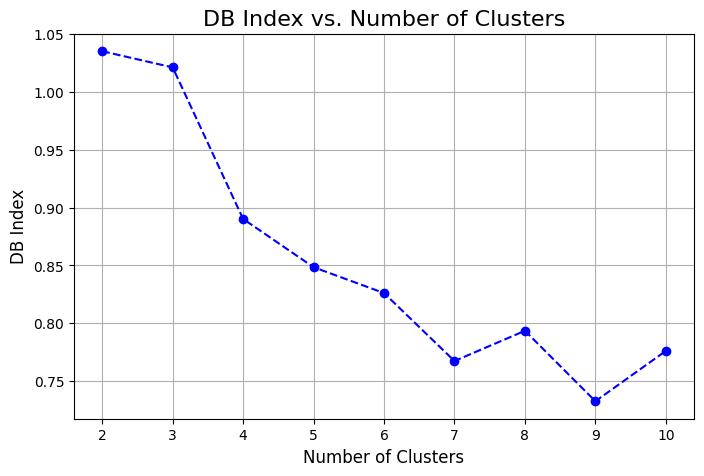

In [168]:
# Plot Davies-Bouldin Index for each cluster count
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), db_scores, marker='o', linestyle='--', color='b')
plt.title('DB Index vs. Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('DB Index', fontsize=12)
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [169]:
# Final KMeans with the optimal number of clusters based on DB Index
optimal_k = np.argmin(db_scores) + 2  # Add 2 because range starts at 2
kmeans_final = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    n_init=100,
    max_iter=1000,
    random_state=42
)
final_labels = kmeans_final.fit_predict(data_pca)

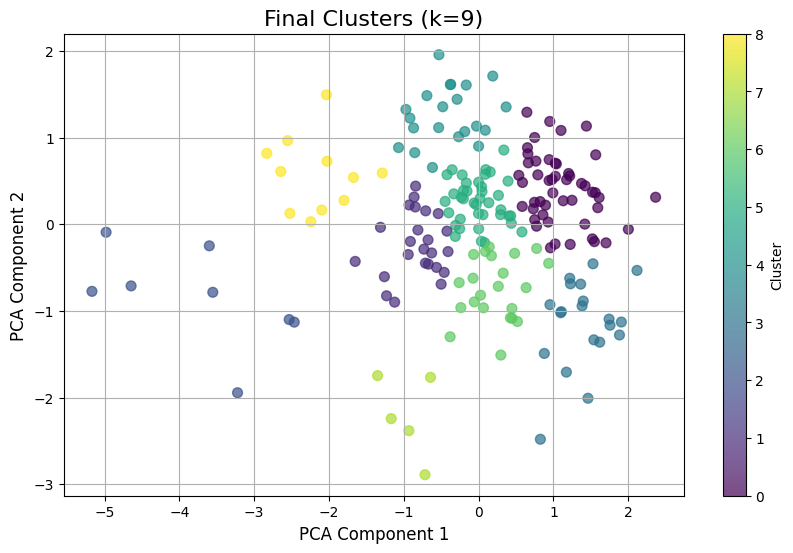

In [170]:
# Visualize final clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    data_pca[:, 0],
    data_pca[:, 1],
    c=final_labels,
    cmap="viridis",
    s=50,
    alpha=0.7
)
plt.title(f"Final Clusters (k={optimal_k})", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid()
plt.show()